In [1]:
from flasher_lib import *

In [2]:
#definir variables
m=5
delta=np.pi/3.7
alpha=np.pi/2-np.pi/m
epsilon=np.pi/36
eta=(np.pi/m)-(epsilon/2)
i=6
j=m+1

In [3]:
def encontrar_indice(modulos, distancia_k):
    suma_modulos = 0
    for idx, modulo in enumerate(modulos):
        suma_modulos += modulo
        if distancia_k < suma_modulos:
            return idx
    return -1  # Si no encuentra un índice adecuado

In [4]:
import numpy as np

# Función de distancia euclidiana entre dos puntos en 2D
def e_distance(p1, p2):
    return np.linalg.norm(p2 - p1)

# Función que calcula los módulos y encuentra índices con remanentes para cualquier j
def r_h_cte(i, j, m, delta, alpha, epsilon, altura, dk):
    modulos = []  # Lista para guardar las distancias euclidianas de los puntos p a lo largo de i para j dado
    resultados = []  # Lista de tuplas para guardar los índices y remanentes encontrados

    # Calcular las distancias euclidianas entre los puntos p(i,j)
    for indice in range(i-1):
        distancia = e_distance(p(indice, j,  m, delta, alpha, epsilon), p(indice + 1, j,  m, delta, alpha, epsilon))
        modulos.append(distancia)
        #print("lista de modulos", modulos)
    
    # Calcular cuántos puntos r(i,j) se pueden crear
    puntos = np.floor(sum(modulos) / dk)
    
    # Encontrar los índices y remanentes para los puntos r(i,j)
    for n in range(int(puntos)):
        indice = encontrar_indice(modulos, dk * (n + 1))
        if indice == -1:
            break
        remanente = dk * (n + 1) - sum(modulos[:indice])
        resultados.append((indice, remanente))
    
    return resultados

# Función que genera los puntos r[i,j]
def nuevo_r(i, j, m, delta, alpha, epsilon, altura, dk):
    # Obtener los índices y remanentes relativos para los puntos r(i,j)
    resultados = r_h_cte(i, j, m, delta, alpha, epsilon, altura, dk)

    # Inicializar lista para almacenar los puntos r(i,j)
    puntos_r = []
    punto_inicial=p(0, j,  m, delta, alpha, epsilon)
    puntos_r.append(punto_inicial)

    # Calcular cada r(i,j)
    for idx, remanente in resultados:
        p_start = p(idx, j,  m, delta, alpha, epsilon)
        p_next = p(idx + 1, j,  m, delta, alpha, epsilon)

        # Calcular la dirección entre p(idx,j) y p(idx+1,j)
        direccion = (p_next - p_start) / e_distance(p_start, p_next)
        
        # Aplicar el desplazamiento basado en el remanente
        desplazamiento = remanente * direccion
        nuevo_punto_r = p_start + desplazamiento
        
        puntos_r.append(nuevo_punto_r)
    
    return puntos_r


In [5]:
altura = 3
distanciak = dk(altura, epsilon, m)

# Obtener r_0_1 como un array
r_0_1_o = np.array(nuevo_r(1, 0, m, delta, alpha, epsilon, altura, distanciak))
r_0_1 = np.array(nuevo_r(1, 0, m, delta, alpha, epsilon, altura, distanciak)).flatten()
print("r_0_1", r_0_1)

# Dirección rho y su vector unitario
direccion_r = rho(1, 0, 0, delta, alpha, eta, epsilon, m)
u_1_array = np.array(u(direccion_r))  # Asegúrate de que sea un array
print("direccion_r_1 (u_1_array)", u_1_array)

# Obtener el punto p(1, 1) como un array
punto_1_1 = np.array(p(1, 1, m, delta, alpha, epsilon))
print("punto_1_1", punto_1_1)

# Dirección phi y su vector unitario
direccion_p = phi(1, 1, delta, epsilon, m)
u_2_array = np.array(u(direccion_p))  # Asegúrate de que sea un array
print("direccion_p_1 (u_2_array)", u_2_array)

# Llamar a la función lineint con arrays correctamente formateados
r_creado = lineint(r_0_1, u_1_array, punto_1_1, u_2_array)
print("r_creado", r_creado)


r_0_1 [1 0]
direccion_r_1 (u_1_array) [-0.43603784  0.89992833]
punto_1_1 [-0.91074737  1.67382176]
direccion_p_1 (u_2_array) [0.8800521  0.47487715]
r_creado [-0.03894229  2.14424881]


In [6]:
def r_orden_nuevo(i, j, k, orden, delta, alpha, eta, epsilon, h, distancia_k): 
    j = j % orden
    #print(f"r_orden_nuevo: i={i}, j={j}, k={k}, orden={orden}")

    if k == 0:
        if i == 0 and j == 0:
            return np.array([1, 0])
        if i==0:
            punto_p= p(0, j, m, delta, alpha, epsilon)
            return np.array(punto_p)
        else:
            puntos_r = nuevo_r(i, j, orden, delta, alpha, epsilon, h, distancia_k)
            #print(f"puntos_r: {puntos_r}")
            if not puntos_r:
                raise ValueError(f"No se generaron puntos r(i,j,0) para i={i}, j={j}")
            return np.array(puntos_r[j])
    
    else:
        punto_r_ijk_km1 = r_orden_nuevo(i, j, k-1, orden, delta, alpha, eta, epsilon, h, distancia_k)
        #print(f"punto_r_ijk_km1: {punto_r_ijk_km1}")
        if punto_r_ijk_km1 is None:
            return None
        punto_p = p(i+k-1, j+1, orden, delta, alpha, epsilon)
        #print(f"punto_p: {punto_p}")
        return lineint(punto_r_ijk_km1, 
                       u(rho(i, j, k-1, delta, alpha, eta, epsilon, orden)), 
                       np.array(punto_p), 
                       u(phi(i+k-1, j+1, delta, epsilon, m)))


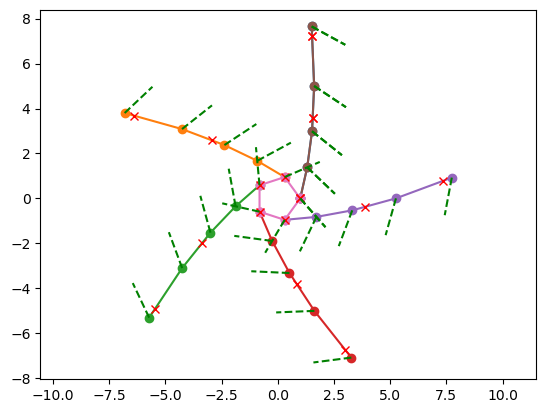

In [7]:
import matplotlib.pyplot as plt
import numpy as np

i_values = range(5)  # Cambia el rango de i si es necesario
j_values = range(m + 1)  # Cambia el rango de j según los pliegues

h = 2  # Altura o algún otro parámetro
distancia_k = dk(h, epsilon, m)  # Calcular la distancia dk

# Inicializar matrices para almacenar coordenadas
x_values_p = np.zeros((len(i_values), len(j_values)))
y_values_p = np.zeros((len(i_values), len(j_values)))

lineas_rho=[]

# Rellenar matrices con los puntos generados por p(i,j)
for i in i_values:
    for j in j_values:
        punto_p = p(i, j, m, delta, alpha, epsilon)  # Generar punto p(i,j)
        x_values_p[i, j] = punto_p[0]
        y_values_p[i, j] = punto_p[1]
        # Etiquetar los puntos
        #plt.text(x_values_p[i, j], y_values_p[i, j], f'p({i},{j})', fontsize=6, ha='right')

# Graficar y conectar los puntos por j
for j in j_values:
    plt.plot(x_values_p[:, j], y_values_p[:, j], 'o-', label=f'j={j}')

# Graficar los puntos con i=0 (primer pliegue)
plt.plot(x_values_p[0, :], y_values_p[0, :], 'o-', label='i=0')

# Llamar a la función nuevo_r() para generar todos los puntos r(i,j) para cada j
for j in j_values:
    puntos_r = nuevo_r(len(i_values), j, m, delta, alpha, epsilon, h, distancia_k)  # Generar puntos r(i,j)
    
    # Graficar los puntos r(i,j) con un marcador distintivo
    for punto in puntos_r:
        plt.plot(punto[0], punto[1], 'rx')  # Marcar los puntos r(i,j) en rojo con una 'x'
        #plt.text(punto[0], punto[1], f'r({punto[0]:.2f}, {punto[1]:.2f})', fontsize=6, ha='right')
    


# Graficar direcciones desde los puntos p(i, j)
line_length = 1.7  # Factor de escala para la longitud de las líneas

for i in i_values:
    for j in j_values:
        punto_p = p(i, j, m, delta, alpha, epsilon)  # Obtener el punto p(i,j)
        direccion_phi = phi(i, j, delta, epsilon, m)  # Obtener la dirección phi
        direccion_u = u(direccion_phi)  # Convertir la dirección a un vector unitario
        
        # Escalar el vector unitario
        direccion_u_scaled = direccion_u * line_length
        
        # Graficar línea de la dirección desde el punto p(i,j)
        plt.plot([punto_p[0], punto_p[0] + direccion_u_scaled[0]], 
                 [punto_p[1], punto_p[1] + direccion_u_scaled[1]], 'g--')  # Línea verde discontinua


# Ajustes de visualización
plt.axis('equal')  # Mantener proporciones
#plt.legend()  # Mostrar leyendas
plt.show()
